<a href="https://colab.research.google.com/github/BurovNV/MyRepo/blob/main/Class_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Создание классификационной модели k ближайших соседей

Определение лучшего значения k

Поиск ближайших k соседей

Создание радиусного классификатора

In [186]:
# импорт
import numpy as np
from sklearn.datasets import (make_blobs, make_circles, make_moons)
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neighbors import NearestNeighbors as NN
from sklearn.neighbors import RadiusNeighborsClassifier as RNN
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
# создание данных
X_blob, y_blob       = datasets.  make_blobs(n_samples=100,
                                             n_features=2,
                                             centers=3,
                                             cluster_std=3,
                                             random_state=42)

X_circles, y_circles = datasets.make_circles(n_samples=100,
                                             noise=0.25,
                                             factor=0.3,
                                             random_state=42)

X_moons, y_moons     = datasets.  make_moons(n_samples=100,
                                             noise=0.15,
                                             random_state=42)

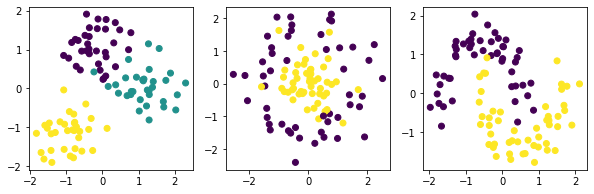

In [95]:
# стандартизация и печать
scaler        = StandardScaler()
X_blob_std    = scaler.fit_transform(X_blob)
X_circles_std = scaler.fit_transform(X_circles)
X_moons_std   = scaler.fit_transform(X_moons)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.scatter(X_blob_std[:, 0], X_blob_std[:, 1], c=y_blob)
plt.subplot(132)
plt.scatter(X_circles_std[:, 0], X_circles_std[:, 1], c=y_circles)
plt.subplot(133)
plt.scatter(X_moons_std[:, 0], X_moons_std[:, 1], c=y_moons)
plt.show()

Как будет видно ниже, при выборе одного соседа будет получена лучшая точность на тренировочных данных одновременно с рваной границей классов, что приведет к ошибкам при валидации.

При n=10 границы плавные, но точность ниже.

При n=100 все точки отнесены к самому многочисленному классу.

Важен баланс.

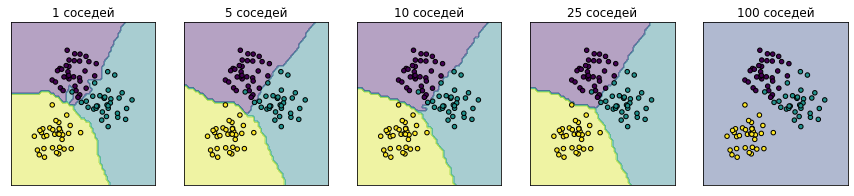

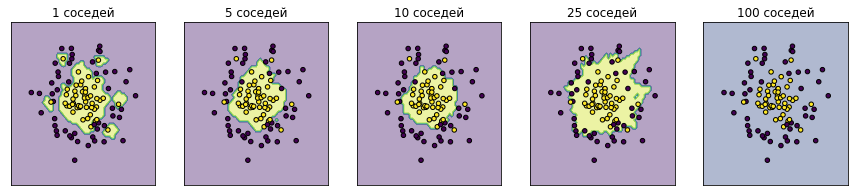

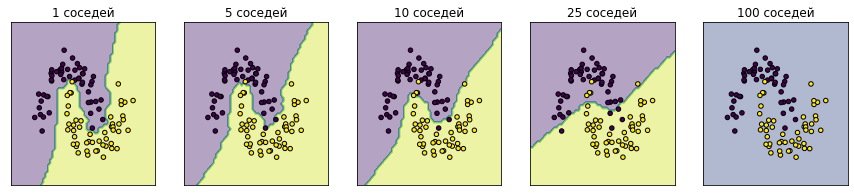

In [112]:
# кол-во соседей - от 1 до кол-ва всех точек в выборке
n_list = [1, 5, 10, 25, 100]
# обучение и печать результатов
for ind, data in enumerate([(X_blob_std, y_blob),
                            (X_circles_std, y_circles),
                            (X_moons_std, y_moons)]):
  # холст
  plt.figure(figsize=(15, 3))
  for ind_, n in enumerate(n_list):
    # обучение классификатора
    knn = KNN(n_neighbors=n,    # обучаем на кол-ве соседей из списка выше
              n_jobs=-1)        # задействовав все ядра
    knn.fit(data[0], data[1])
    # печать
    # субплот 1 строка 5 колонок
    plt.subplot(1, 5, ind_+1)
    # настройка минимума и максимума для создания поля с точками
    x_min, x_max = data[0][:, 0].min()-1, data[0][:, 0].max()+1
    y_min, y_max = data[0][:, 1].min()-1, data[0][:, 1].max()+1
    # поле с точками для классификации с шагом 0,1 между точками
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    # предикты для этого поля
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # окраска поля по контуру классов из предикта
    plt.contourf(xx, yy, Z, alpha=0.4)
    # вывод оригинального датасета с истинными метками
    plt.scatter(data[0][:, 0], data[0][:, 1], c=data[1],
                s=20,           # диаметр точек
                edgecolor='k')  # цвет окантовки точек
    plt.title(f'{n} соседей')
    plt.xticks([])
    plt.yticks([])

plt.show()

Определение лучшего значения k решается при сеточном поиске гиперпараметров

Поиск ближайших 5 соседей для точки

In [183]:
# возьмем точку возле центра графика
point = np.array([[0.2, 0.2]])   # шейп должен совпадать с трейном!
# создание экземпляра
nn = NN(n_neighbors=5).fit(X_blob_std)
# нахождение ближайших 5 точек - вернет расстояния и индексы точек!
nearest_5_distances, indexes = nn.kneighbors(point,
                                   return_distance=True) # вернуть ли расстояния

In [184]:
# печать расстояний
nearest_5_distances

array([[0.15285995, 0.16245655, 0.17480531, 0.18782665, 0.19708163]])

In [185]:
# печать координат соседей
X_blob_std[indexes]

array([[[0.15914782, 0.05270009],
        [0.09122014, 0.32066098],
        [0.0339797 , 0.2547189 ],
        [0.01534251, 0.23435785],
        [0.36642184, 0.0944304 ]]])

Радиусный KNN

Как обычно нужно подбирать параметр - сам радиус

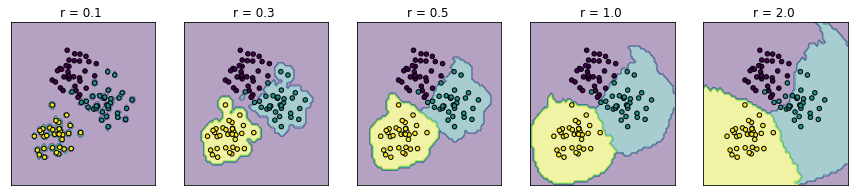

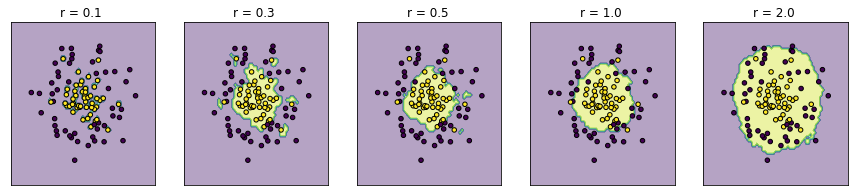

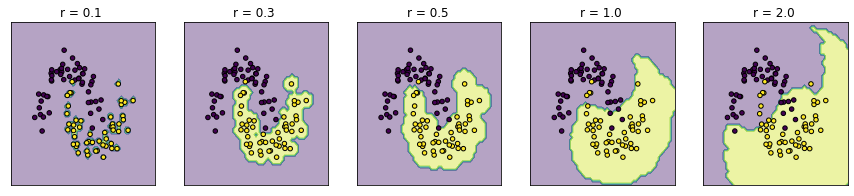

In [195]:
# кол-во соседей - от 1 до кол-ва всех точек в выборке
radius = [0.1, 0.3, 0.5, 1, 2]
# обучение и печать результатов
for ind, data in enumerate([(X_blob_std, y_blob),
                            (X_circles_std, y_circles),
                            (X_moons_std, y_moons)]):
  # холст
  plt.figure(figsize=(15, 3))
  for ind_, r in enumerate(radius):
    # обучение классификатора
    rnn = RNN(n_neighbors=n,    # обучаем на кол-ве соседей из списка выше
              radius=r,         # размер окрестности
              outlier_label=0,  # как пометить выбросы у которых нет соседей 
                                # в пределах радиуса
              n_jobs=-1)        # задействовав все ядра
    rnn.fit(data[0], data[1])
    # печать
    # субплот 1 строка 5 колонок
    plt.subplot(1, 5, ind_+1)
    # настройка минимума и максимума для создания поля с точками
    x_min, x_max = data[0][:, 0].min()-1, data[0][:, 0].max()+1
    y_min, y_max = data[0][:, 1].min()-1, data[0][:, 1].max()+1
    # поле с точками для классификации с шагом 0,1 между точками
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    # предикты для этого поля
    Z = rnn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # окраска поля по контуру классов из предикта
    plt.contourf(xx, yy, Z, alpha=0.4)
    # вывод оригинального датасета с истинными метками
    plt.scatter(data[0][:, 0], data[0][:, 1], c=data[1],
                s=20,           # диаметр точек
                edgecolor='k')  # цвет окантовки точек
    plt.title(f'r = {r:.1f} ')
    plt.xticks([])
    plt.yticks([])

plt.show()